<h3> Machine Learning Project 6 </h3>
    <p> Liora Wachsstock </p>
    

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
#constants
UPPER = 10
LOWER = -2
k = 3
lams = [0.1, 1, 10, 100]

In [3]:
def generate_data(n):
    rng = np.random.default_rng()
    x = (UPPER - LOWER) * rng.random(n) + LOWER
    y = f(x)
    data = np.stack((x, y), axis=-1)
    
    return pd.DataFrame(data, columns=("X", "Y"))

def f(x):
    return np.square(x) + 10

In [4]:
def quadratic_regression(data):
    #math from https://www.varsitytutors.com/hotmath/hotmath_help/topics/quadratic-regression
    
    powers = np.array([4,3,2,3,2,1,2,1,0])
    
    #repeat each of the x values 9 times for the powers
    x_s = np.repeat(np.array(data['X']), [powers.size]).reshape(data['X'].size, powers.size) 
    
    coeff_m = np.sum(np.power(x_s, powers), axis=0).reshape(3,3)
    
    y_col = np.vstack((np.sum(np.square(data['X'])*data['Y']), np.sum(data['X']*data['Y']), np.sum(data['Y'])))
    
    result = np.matmul(np.linalg.inv(coeff_m), y_col)

    return result

def g(abc, x): # create the actual hypothesis line
    a,b,c = abc
    y = a*np.square(x) + b*x + c # equation of the curve
    return y

def curve(abc):
    x = np.arange(-25, 25 ) # points on the curve
    y = g(abc, x) # equation of the estimated y
    return x,y

#squared error
def error(data, weights):
    yhat = g(weights, data['X'])
    return np.sum(np.square(data['Y'] - yhat)) #SSE

# regularized error
def e_reg(lam, data, weights):
    return error(data, weights) + lam*np.sum(np.square(weights))

#ridge regression
def ridge_reg(lam, x_series, y):
    
    #add a dummy x0 = 1
    x = np.array(x_series).reshape(x_series.size,1)
    x = np.insert(x, 0,1,axis=1)

    return np.dot(np.linalg.inv(np.dot(x.T, x) + lam*np.identity(x.shape[1])), np.dot(x.T, y))
    
#separate data for model selection
def separate_data(data, group_num, k):
    num_in_group = int(np.floor(data.shape[0] / k))
    v_data = data[group_num*num_in_group: group_num*num_in_group + num_in_group]
    
    tr_data = np.vstack((data[:group_num*num_in_group], data[group_num*num_in_group + num_in_group :]))
    return v_data, pd.DataFrame(tr_data, columns=("X", "Y"))

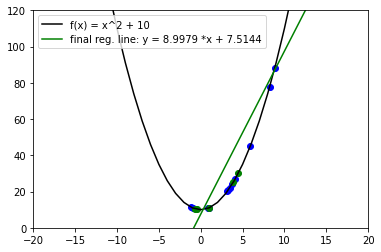

In [5]:
fig, ax = plt.subplots()
plt.xlim([-20,20])
plt.ylim([0,120])

#generate data
train = generate_data(12)
test = generate_data(5)

#check for intersecting values and re-sample if necessary
while (np.intersect1d(train.T[0], test.T[0]).size > 0): #only have to check if there are identical values in x values
    print(np.intersect1d(train.T[0], test.T[0]))
    test = generate_data(5)

# plot the points
ax.scatter(train['X'], train['Y'], c='b')
ax.scatter(test['X'], test['Y'], c='g')


# quadratic regression
result = quadratic_regression(train).flatten()
x, y = curve(result)


#model selection and ridge regression with regularization
models = []
# ------- Model selection ----------------
for lam in lams:
    error_history = []
    
    # ------------------- start cross validation ----------
    for i in range(k - 1): #k groups, so k - 1 divisions of the data needed
        validation_set, train_set = separate_data(train, i, k)
        rdge = ridge_reg(lam, train_set['X'], train_set['Y'])
        
        lin_reg_result = np.insert(rdge, 0, 0) # add in a zero a term so it's a straight line when we plot it
        error_history.append(e_reg(lam, validation_set, lin_reg_result))
        # ---------------- end cross validation -----------------
    
    #for this model, get Rcv
    R_cv = np.mean(error_history)
    
    #re-train on the whole data set
    rdge = ridge_reg(lam, train_set['X'], train_set['Y'])  
    models.append((R_cv, rdge)) #keep track of R and g(x) for each model
# -------- end model selection -----------------

# find the best model
best_lambda = lams[np.argmin(np.array(models, dtype=object).T[0])] # get the one with the smallest CV error
best_CV_error = min(models, key = lambda t: t[0])[0]

# retrain on the whole data set with the best lambda
final_result = ridge_reg(best_lambda, train_set['X'], train_set['Y'])

# plot the lines/curves
ax.plot(x, y, 'k',label="f(x) = x^2 + 10")
xlin_final, ylin_final = curve(np.insert(final_result, 0, 0)) # add in a zero a term so it's a straight line when we plot it

title = f'y = {round(final_result[0], 4)} *x + {round(final_result[1], 4)}'
ax.plot(xlin_final, ylin_final, 'g', label = 'final reg. line: ' + title)


ax.legend()
plt.show()

In [6]:
print("a) Training Set values: ")
print(train)
print("   Test Set values: ")
print(test)

print("\nb) Equation of non-linear regression relation: y =", result[0],"*(x^2) + ",result[1], "*x +", result[2])
print("   In-sample error: ", error(train, result))
print("   Test error: ", error(test, result))

print("\nc) ")
for i, lam in enumerate(lams):
    print("lambda", lam, ": CV error was", models[i][0])
    
print ("\nd) The best lamda after performing CV:", best_lambda)

print("\ne) Final Equation of regression relation after regularization: ")
print("     y =", final_result[0], "*x +", final_result[1])
print("     Final In-sample error (12 points were used): ", error(train, np.insert(final_result, 0, 0)) )
print("     Final Test error: ", error(test, np.insert(final_result, 0, 0)))

print("\nf) No, I did not obtain the best lambda analytically.")

errors = {
    'CV error': best_CV_error,
    'Final test error': error(test, np.insert(final_result, 0, 0)),
    'Final in sample error': error(train, np.insert(final_result, 0, 0))
}

lst = sorted((value, key) for (key,value) in errors.items())
errors = dict([(k,v) for v,k in lst])
print("\ng) Errors in ascending order")
for name, err in errors.items():
    print(name, ":", err)

a) Training Set values: 
           X          Y
0  -1.130658  11.278388
1   8.240960  77.913427
2   8.852082  88.359351
3   4.130258  27.059033
4   3.176678  20.091284
5   3.759873  24.136647
6   0.981778  10.963888
7   3.488573  22.170143
8   0.822476  10.676466
9  -0.960229  10.922041
10  3.269756  20.691302
11  5.906667  44.888712
   Test Set values: 
          X          Y
0  0.961339  10.924173
1 -0.502207  10.252211
2  3.902269  25.227704
3 -0.714647  10.510720
4  4.500839  30.257548

b) Equation of non-linear regression relation: y = 0.9999999999999991 *(x^2) +  1.7763568394002505e-14 *x + 10.0
   In-sample error:  3.626235809119947e-26
   Test error:  7.465779607011656e-27

c) 
lambda 0.1 : CV error was 708.6251128252086
lambda 1 : CV error was 876.5113991428257
lambda 10 : CV error was 3406.802109548251
lambda 100 : CV error was 7957.551817951144

d) The best lamda after performing CV: 0.1

e) Final Equation of regression relation after regularization: 
     y = 8.99794591162